<a href="https://colab.research.google.com/github/PomesHouse/SkillTreePython-DeepLearning/blob/main/04.Paper-with-code/ch04_01_UNet_Image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ch04.01 UNet-Image segmentation

* 날짜:
* 이름:

## 학습내용
    - Image segmentation에 대해 이해한다.
    - UNet 모델에 대해 이해한다.
    - 이미지 분절 작업을 수행한다.

## Image Segmentation

![](https://github.com/yebiny/Image-Segmentation-TF2/blob/main/imgs/seg_type.png?raw=true)


![](https://github.com/yebiny/Image-Segmentation-TF2/blob/main/imgs/seg_model.png?raw=true)

## 모델: UNet
---

![]( https://github.com/yebiny/Image-Segmentation-TF2/blob/main/imgs/unet2.png?raw=true)

#### **레포지토리 임포트**

https://github.com/karolzak/keras-unet

```
! git clone https://github.com/karolzak/keras-unet
```


In [ ]:
! git clone https://github.com/karolzak/keras-unet

Cloning into 'keras-unet'...
remote: Enumerating objects: 1234, done.
remote: Counting objects: 100% (98/98), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 1234 (delta 44), reused 75 (delta 34), pack-reused 1136
Receiving objects: 100% (1234/1234), 31.94 MiB | 16.90 MiB/s, done.
Resolving deltas: 100% (372/372), done.


In [ ]:
import sys, os, glob
sys.path.append('/content/keras-unet')

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import utils, callbacks
from keras_unet.models import custom_unet
from PIL import Image

#### **모델 생성**

In [ ]:
from keras_unet.models import vanilla_unet

model = vanilla_unet(input_shape=(572, 572, 3))
model.summary()

In [ ]:
utils.plot_model(model, show_shapes = True)

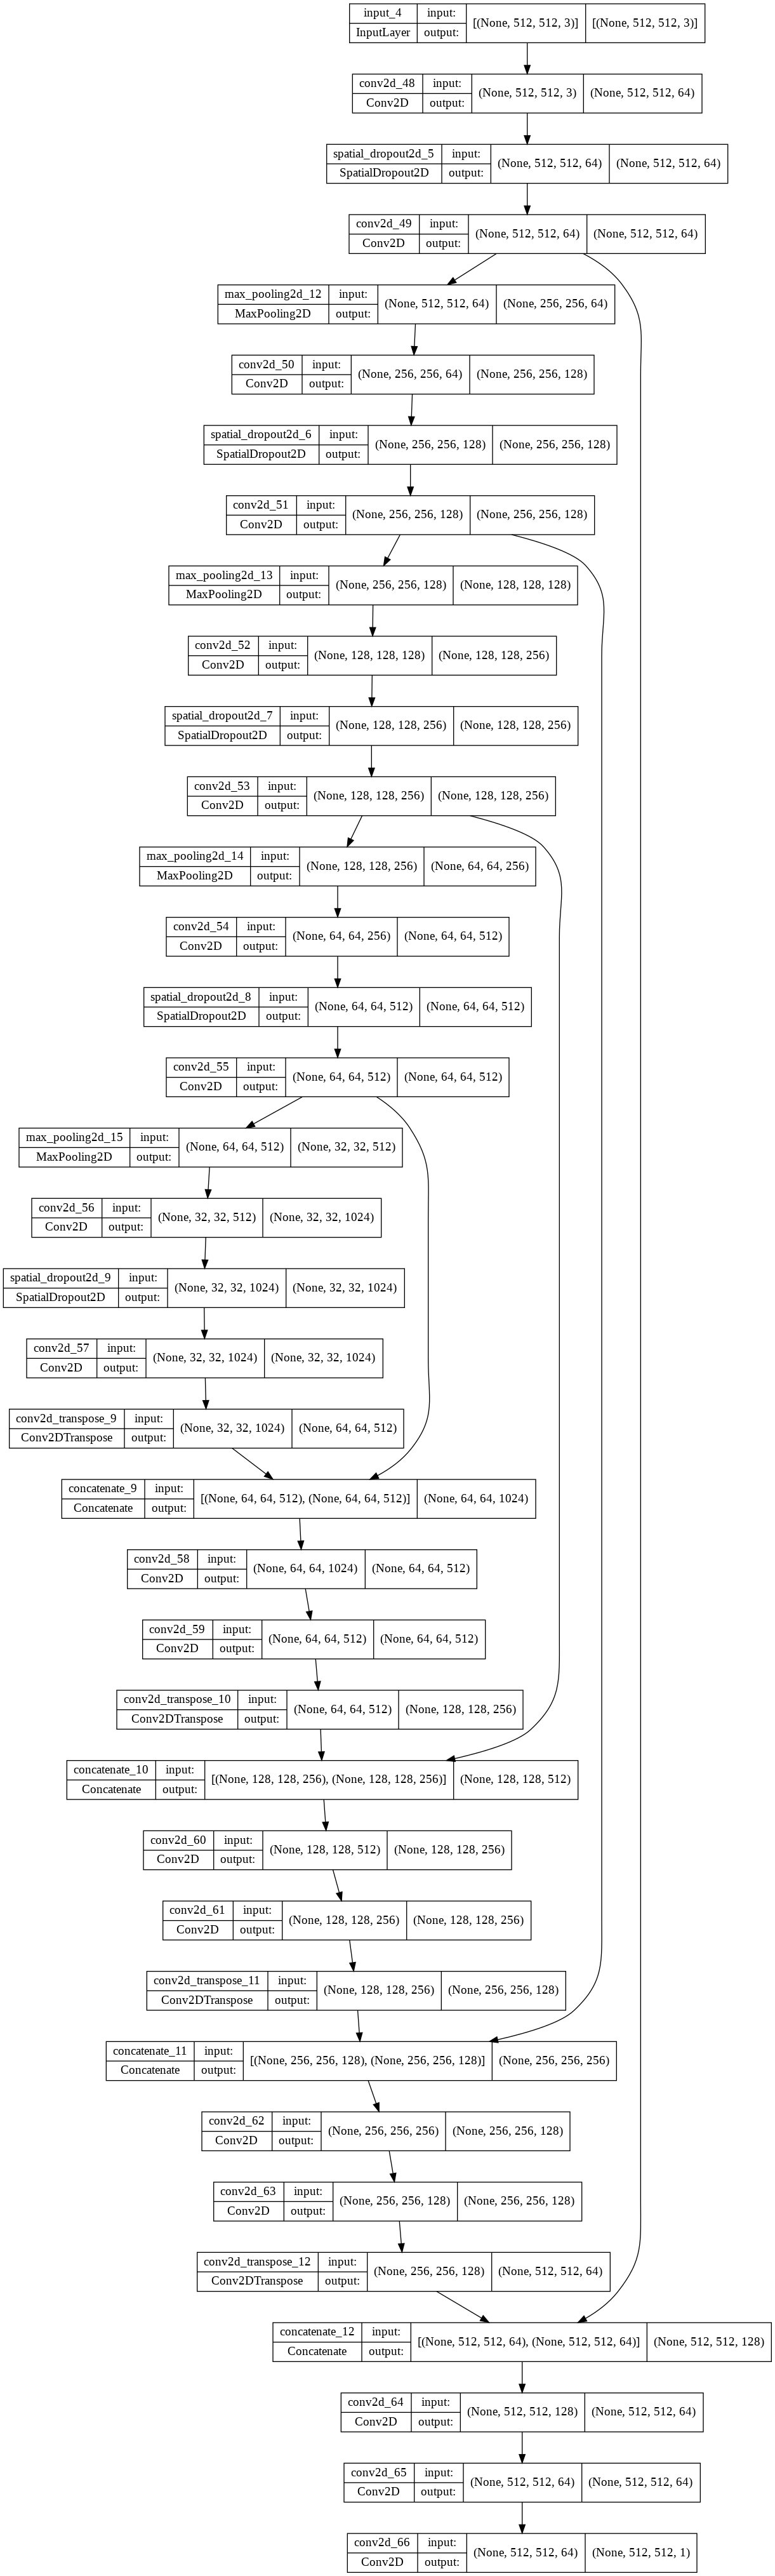

In [ ]:
from keras_unet.models import custom_unet

model = custom_unet(
    input_shape=(512, 512, 3),
    use_batch_norm=False,
    num_classes=1,
    filters=64,
    dropout=0.2,
    output_activation='sigmoid')
utils.plot_model(model, show_shapes = True)

## 데이터셋: Whale-tails
---

### **| 데이터 처리**

#### **데이터 경로 확보**

In [ ]:
img_paths = glob.glob('/content/keras-unet/input/whales/*jpg')
mask_paths = glob.glob('/content/keras-unet/input/whales/*png')
print(len(img_paths), img_paths[0])
print(len(mask_paths), mask_paths[0])

500 /content/keras-unet/input/whales/00d641885.jpg
148 /content/keras-unet/input/whales/00e4afee9.png


In [ ]:
img_paths = [mask_path.replace('png', 'jpg') for mask_path in mask_paths]
print(len(img_paths), img_paths[0])

148 /content/keras-unet/input/whales/00e4afee9.jpg


#### **넘파이 변환**

In [ ]:
from PIL import Image
imgs = []
masks = []
for img_path, mask_path in zip(img_paths, mask_paths):
    # path2img
    img = Image.open(img_path).resize( (384, 384) )
    img = np.array(img)
    imgs.append(img)

    # path2mask
    mask = Image.open(mask_path).resize( (384, 384) )
    mask = np.array(mask)
    masks.append(mask)
imgs = np.asarray(imgs)
masks = np.asarray(masks)
imgs.shape, masks.shape

((148, 384, 384, 3), (148, 384, 384))

In [ ]:
masks = np.expand_dims(masks, 3)
imgs.shape, masks.shape

((148, 384, 384, 3), (148, 384, 384, 1))

#### **데이터 확인**

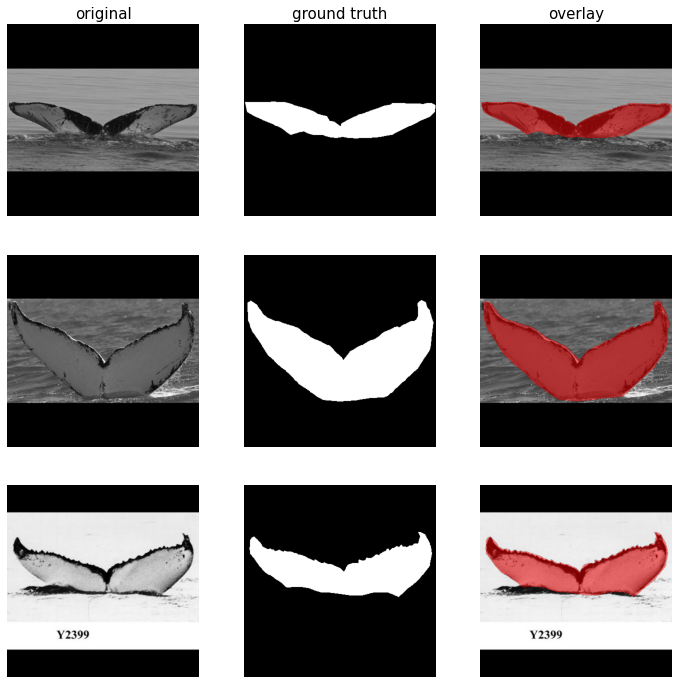

In [ ]:
from keras_unet.utils import plot_imgs
plot_imgs(imgs, masks, nm_img_to_plot = 3)

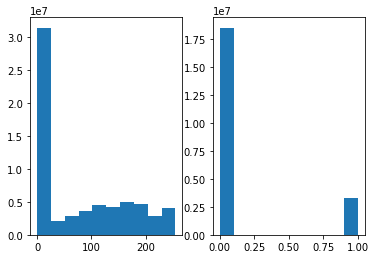

In [ ]:
plt.subplot(121); _ = plt.hist(imgs.flatten())
plt.subplot(122); _ = plt.hist(masks.flatten())

In [ ]:
mn, mx = np.min(imgs.flatten()), np.max(imgs.flatten())
print(f'인풋 이미지의 값 범위: {mn}, {mx}')
print(f'마스크의 값 범위: { set(mask.flatten() ) }')

인풋 이미지의 값 범위: 0, 255
마스크의 값 범위: {0, 1}


#### **전처리**

In [ ]:
def whale_preprocess(imgs, masks):
    imgs = imgs/255.0
    return imgs, masks

인풋 이미지의 값 범위: 0.0, 1.0
마스크의 값 범위: {0, 1}


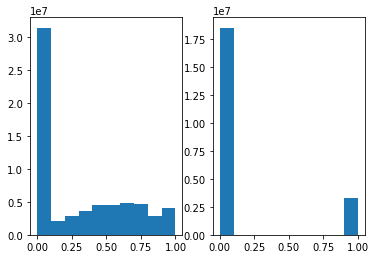

In [ ]:
imgs_ds, masks_ds = whale_preprocess(imgs, masks)
mn, mx = np.min(imgs_ds.flatten()), np.max(imgs_ds.flatten())
print(f'인풋 이미지의 값 범위: {mn}, {mx}')
print(f'마스크의 값 범위: { set(masks_ds.flatten() ) }')
plt.subplot(121); _ = plt.hist(imgs_ds.flatten())
plt.subplot(122); _ = plt.hist(masks_ds.flatten())

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(imgs_ds, masks_ds, 
                                                    test_size = 0.1, 
                                                    random_state = 0)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((133, 384, 384, 3), (15, 384, 384, 3), (133, 384, 384, 1), (15, 384, 384, 1))

#### **이미지 증강**

In [ ]:
from keras_unet.utils import get_augmented
train_gen = get_augmented(x_train, y_train, 
                          batch_size = 2, 
                          data_gen_args = dict(rotation_range = 5.0,
                                              height_shift_range = 0.05,
                                              width_shift_range = 0.05,
                                              shear_range = 40,
                                              horizontal_flip = True,
                                              vertical_flip = False,
                                              fill_mode = 'constant'))

(2, 384, 384, 3) (2, 384, 384, 1)


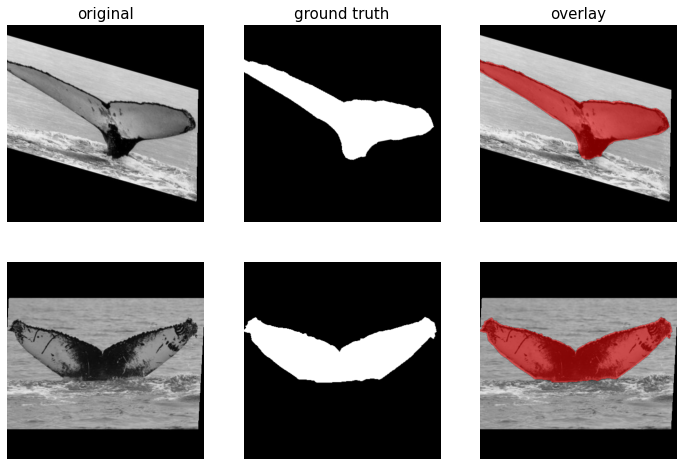

In [ ]:
samples = next(train_gen)
xs, ys = samples
print(xs.shape, ys.shape)
plot_imgs(xs, ys, nm_img_to_plot = 2)

### **| 모델 생성 및 학습**

#### **모델 생성**

In [ ]:
model = custom_unet( (384, 384, 3),
                    filters = 32, output_activation='sigmoid')
model.summary()

#### **컴파일 및 학습**

In [ ]:
# 콜백-체크포인트
ckp = callbacks.ModelCheckpoint('unet_whale.h5',
                                monitor = 'val_loss',
                                save_best_only = True)

In [ ]:
from keras_unet.metrics import iou

model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = [iou] # 케라스에서 iou 함수 지원하지 않음 
              )

In [ ]:
history = model.fit(train_gen,
                    epochs = 50,
                    steps_per_epoch = 200,
                    validation_data = (x_test, y_test),
                    callbacks = [ckp])

Epoch 1/50
200/200 [==============================] - 30s 152ms/step - loss: 0.4385 - iou: 0.2475 - val_loss: 25.8690 - val_iou: 0.2132
Epoch 2/50
200/200 [==============================] - 25s 123ms/step - loss: 0.2673 - iou: 0.3502 - val_loss: 1.8831 - val_iou: 0.3315
Epoch 3/50
200/200 [==============================] - 24s 121ms/step - loss: 0.2071 - iou: 0.4433 - val_loss: 0.1534 - val_iou: 0.6010
Epoch 4/50
200/200 [==============================] - 23s 117ms/step - loss: 0.1790 - iou: 0.5058 - val_loss: 1.3484 - val_iou: 0.3741
Epoch 5/50
200/200 [==============================] - 24s 121ms/step - loss: 0.1521 - iou: 0.5652 - val_loss: 0.1649 - val_iou: 0.6385
Epoch 6/50
200/200 [==============================] - 24s 122ms/step - loss: 0.1480 - iou: 0.5783 - val_loss: 0.1020 - val_iou: 0.7212
Epoch 7/50
200/200 [==============================] - 23s 117ms/step - loss: 0.1332 - iou: 0.6122 - val_loss: 0.1170 - val_iou: 0.6984
Epoch 8/50
200/200 [==============================] - 

#### **Plot training history**

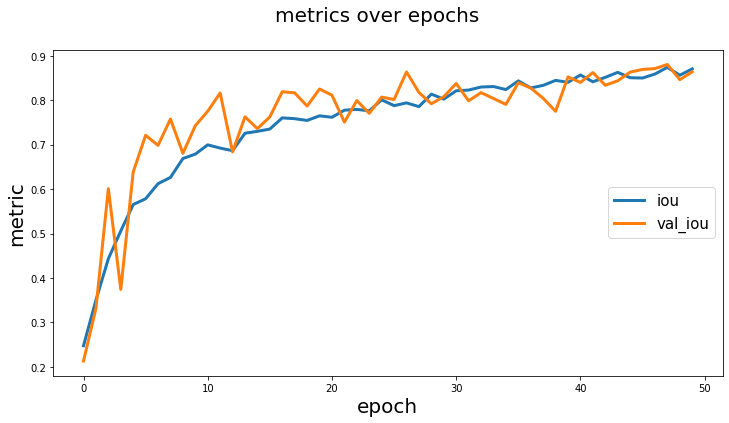

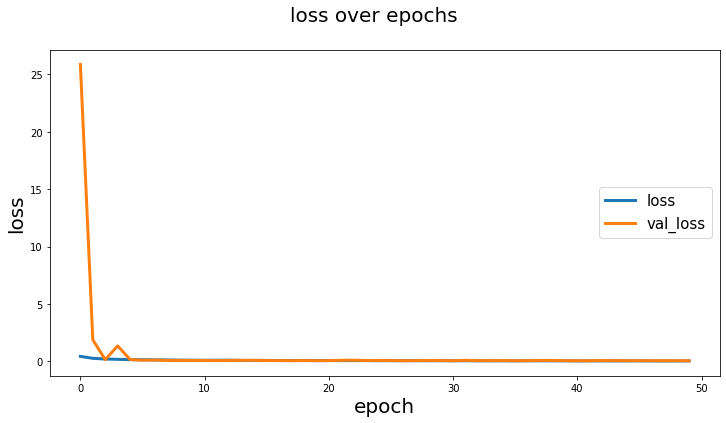

In [ ]:
from keras_unet.utils import plot_segm_history

plot_segm_history(
    history, # required - keras training history object
    metrics=['iou', 'val_iou'], # optional - metrics names to plot
    losses=['loss', 'val_loss']) # optional - loss names to plot

#### **Plot original + ground truth + pred + overlay (pred on top of original)**

In [ ]:
y_pred = model.predict(x_test)
print(y_test.shape, y_pred.shape)

(15, 384, 384, 1) (15, 384, 384, 1)


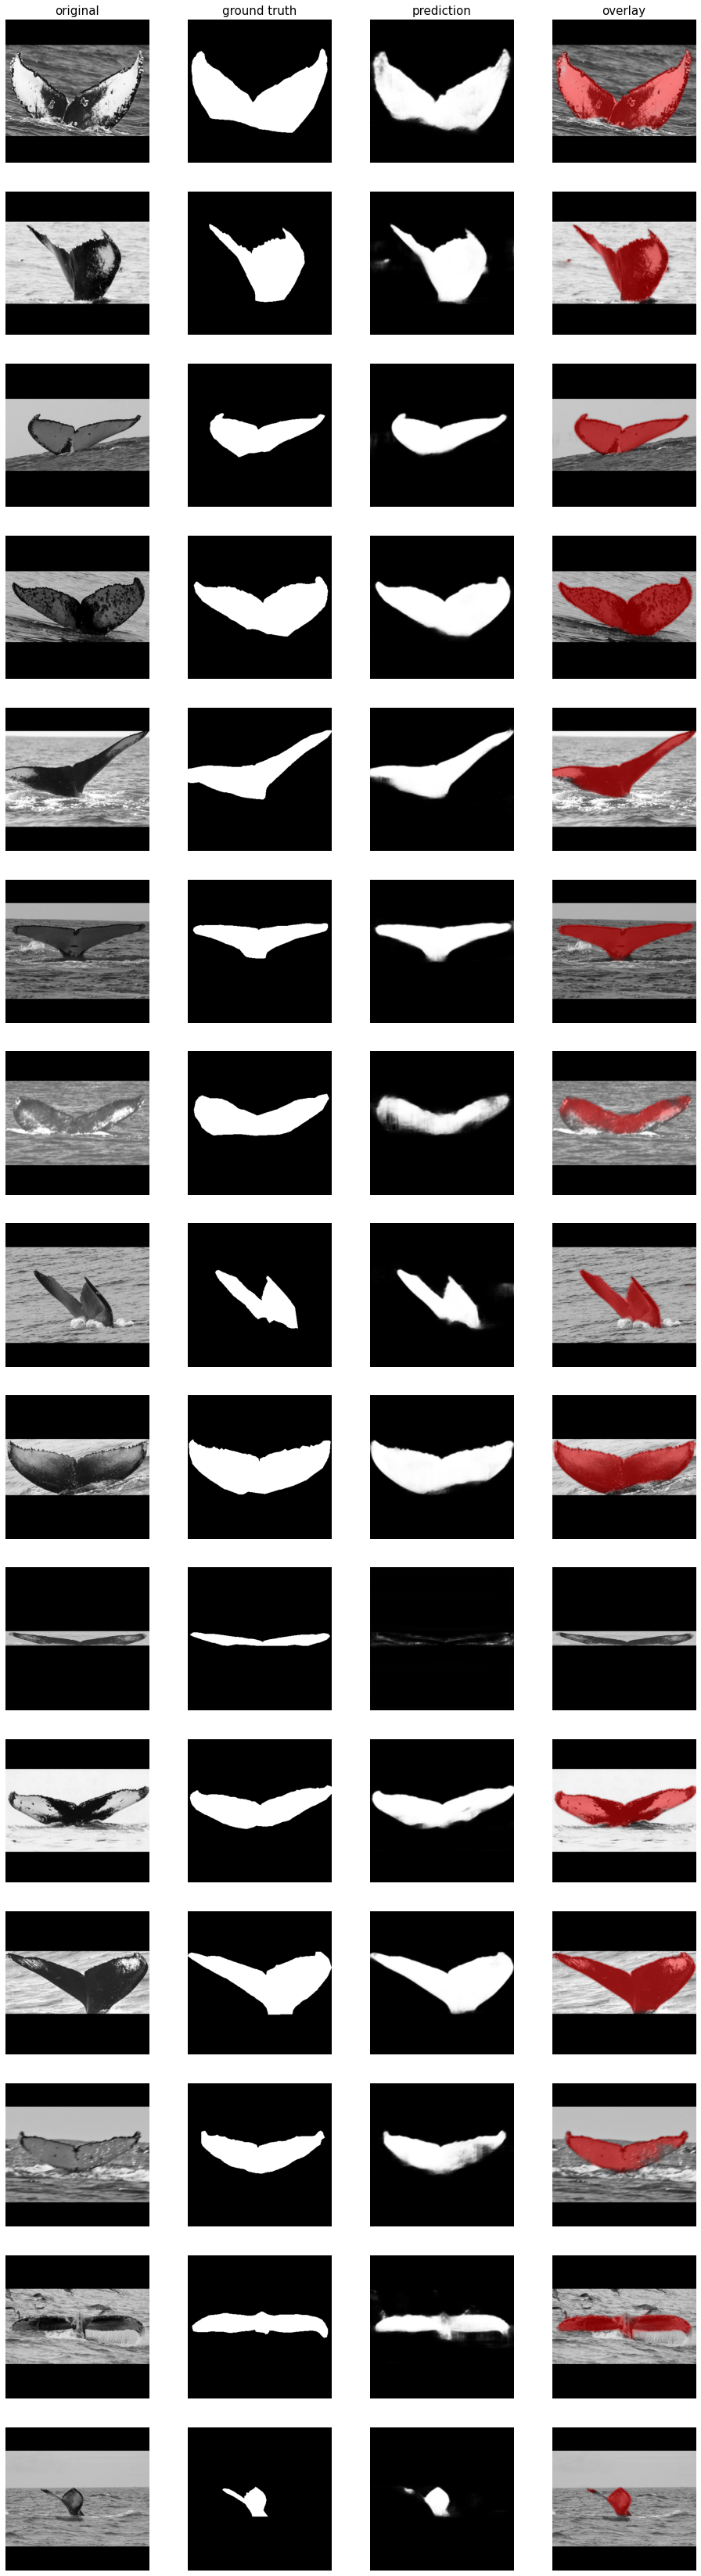

In [ ]:
plot_imgs(org_imgs = x_test, 
          mask_imgs = y_test, 
          pred_imgs = y_pred,
          nm_img_to_plot = 15, )

## 데이터셋: kz-isbi-challenge
---

https://github.com/karolzak/keras-unet/blob/master/notebooks/kz-isbi-challenge.ipynb